In [7]:
import random
from typing import Callable, Dict, List, Tuple, TypeVar, DefaultDict
import math

FeatureVector = Dict[str, int]
WeightVector = Dict[str, float]
Example = Tuple[FeatureVector, int]

# Linear Classification vanilla python (no external libraries)

### From this video https://www.youtube.com/watch?v=WcaMiqJR09s
### And this video https://www.youtube.com/watch?v=bl2WgBLH0tI


### Define Some Utils

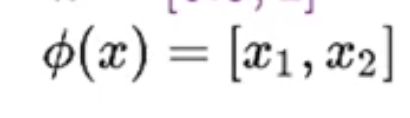

In [8]:
# creates a feature vector for this exmaple
def phi(x):
    return [x[0], x[1]]

In [9]:
# dots two vectors
def dot(x, y):
    sum = 0
    for i in range(len(x)):
        sum += x[i] * y[i]
    return sum

# multiply a vector by a scalar
def vector_scalar_multiply(vector, scalar):
    return [round(num * scalar) for num in vector]

# multiply vector by another vector
def vector_vector_multiply(vector_a, vector_b):
    return [vector_a[i] * vector_b[i] for i in range(len(vector_a))]

# Sum a list of vectors
def vector_summation(vectors):
    summed_vector = [0 for _ in vectors[0]]
    for v in vectors:
        for i in range(len(v)):
            summed_vector[i] += v[i]

    return summed_vector

# Divide a vector by a scalar
def vector_scalar_division(vector, scalar):
    return [round(v / scalar, 3) for v in vector]


### Test Utils

In [10]:
print('should be [2,3]')
print(phi([2,3]))

should be [2,3]
[2, 3]


In [11]:
print("should be 3")
print(dot([1,2], [1,1]))

should be 3
3


### Define predict

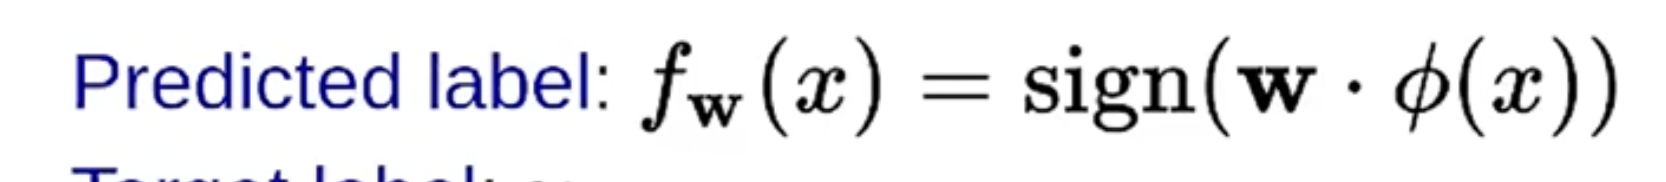

Since this is linear classification, we want our prediction to be yes or no. So we define sign function to turn a number into either +1 or -1 

(Technically it can also be 0, but I don't understand that part tbh)

In [12]:
def sign(x):
    if x > 0:
        return 1
    if x < 0:
        return -1
    else: 
        return 0

In [13]:
# Use sign on our prediction since this is a classifier
def sign_predict(x, w):
    return sign(dot(w, phi(x)))

# test
print("should be 1:", sign_predict([2,2], [.2,4]))

# test
print("should be -1:", sign_predict([-2,-2], [.2,4]))

should be 1: 1
should be -1: -1


### Define Loss

For linear classification, loss is a bit different.

We'll start with definining zero-one loss, which just 1 if the result of the prediction doesn't match, else zero.

So no loss if it agrees, 1 loss if it disagrees.

This gives us a binary result of if the predictor was correct or not. 

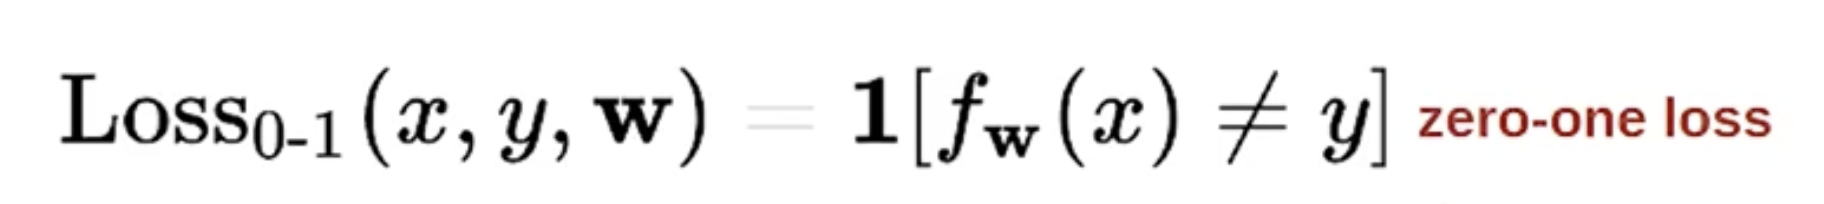

In [14]:
def zero_one_loss(x, y, w):
    return 1 if sign_predict(x, w) != y else 0

Let's test this with a few different weights, just for fun

In [15]:
#This prints zero because it gives correct answer
# ([0,2] dot [.5, 1] is 2, and sign(2) is 1, and y is 1)
print("loss example ", zero_one_loss([0,2], 1, [.5, 1])) 

#This prints one because it gives incorrect answer
# ([-2,0] dot [.5, 1] is -1, and sign(-1) is -1, and y is 1)
print("loss example ", zero_one_loss([-2,0], 1, [.5, 1])) 

loss example  0
loss example  1


Now let's quickly define train loss for this

In [16]:
d_train = [[[0,2], 1], [[-2,0], 1], [[1,-1], -1]]

In [17]:
def zero_one_train_loss(w, train_data):
    train_loss = 0
    for train_example in train_data:
        train_loss += zero_one_loss(train_example[0], train_example[1], w)
    return round(train_loss / len(train_data),3)
    
# now lets test!
print(zero_one_train_loss([.5,1], d_train))
# this should give us .33 since 2 are right and 1 is wrong. 

0.333


### A problem with zero one loss

Let's think forward to the future for a bit... 

When we feed this to gradient descent, what will the gradient be?

Imagine your weights are WAY too high, and need to be reduced.... 

So you take the gradient of the loss function, and that tells you HOW the output will change as you adjust the input a tiny bit.

Well if your weights are way too high you get +1, and if you adjust them a tiny bit you STILL get +1....

So the gradient is flat!! 😭😭😭😭😭

It's either 1, or 0, with no slope!!

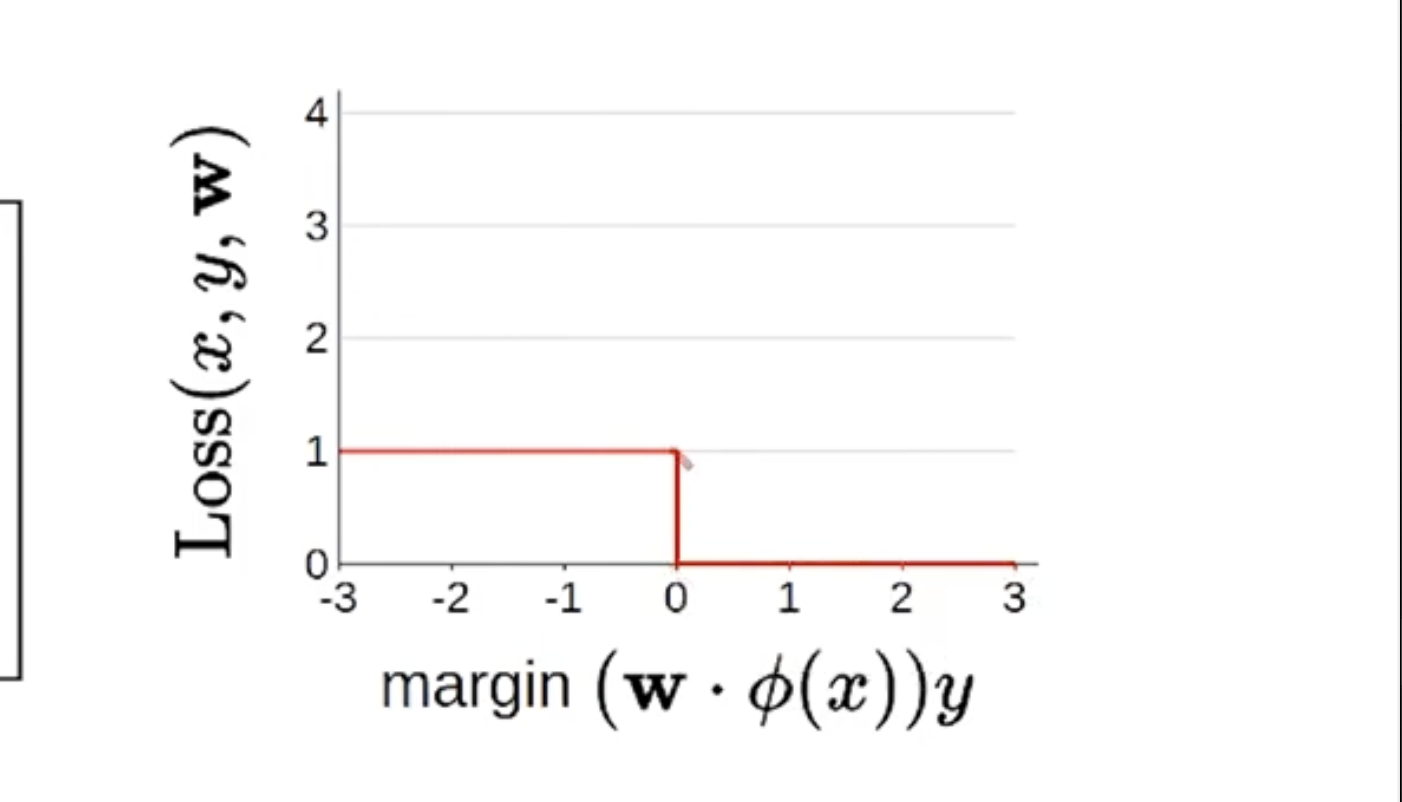

Now without a slope, we can't compute a gradient, and so we can't know which way to go.

SO we need a loss function that will give us a gradient in the direction we want to go. 



## Enter HINGE LOSS

Hinge loss returns not a binary value of if our prediction is correct or incorrect, but rather a number representing how correct we are. It uses "Margin" which is the raw (before sign) result, * y.

So let's look at a few cases:

If the correct classification is 1, and our raw result was 1, that is correct. However, if our raw result is 100, that is even considered MORE correct in a way. It sort of represents how confident we are.

And vice verse with classification of -1. If our answer is -50 (-1 * -50 = 50) then we have a high margin. 

So we'll use this "confidence level" to train our model 

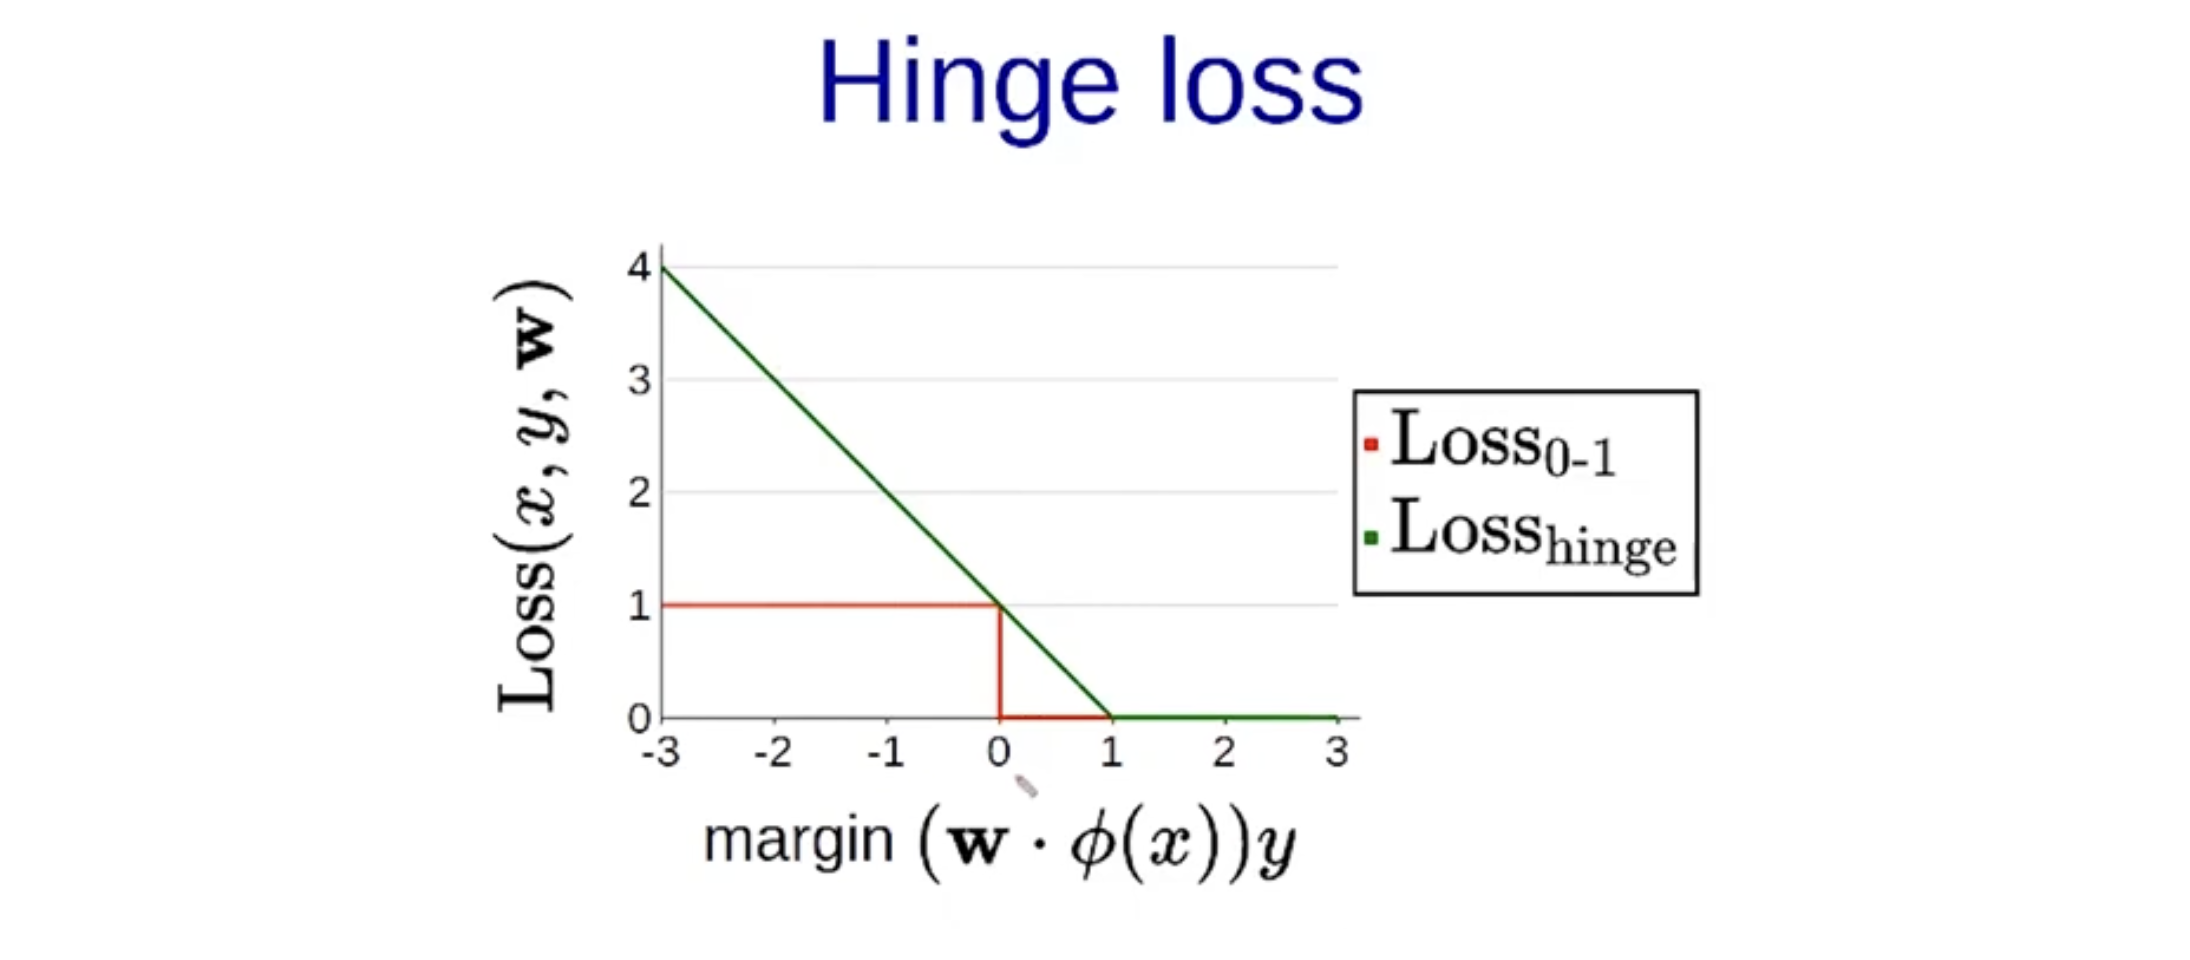

Notice in this image that there is a gradient going down towards 0 loss, and then at 0 loss it goes flat. 

So we will have a way to travel downhill given a loss.




### Define Hinge Loss

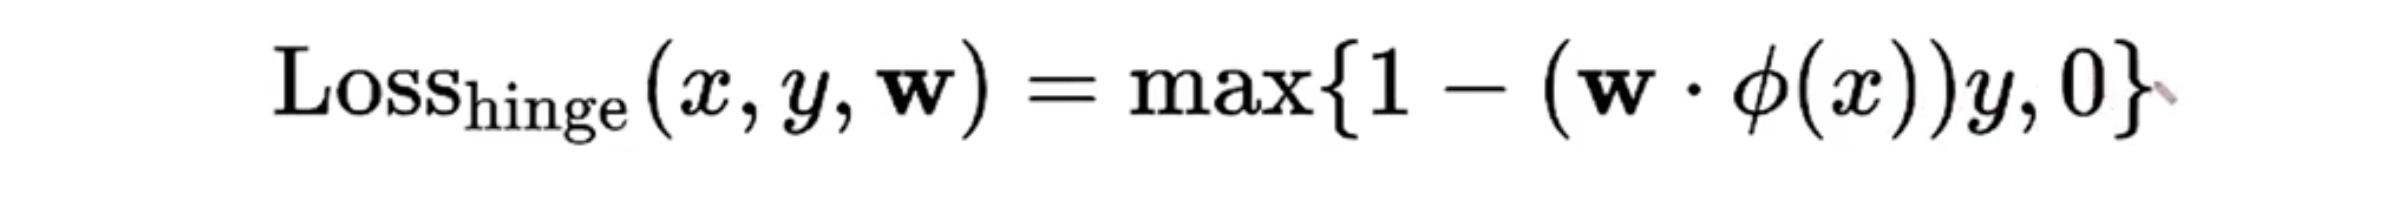



In [18]:
# when we were calculating sign_loss we used a predict that used sign, but for hinge we don't want to sign
def predict(x, w):
    return dot(w, x)


def hinge_loss(x, y, w):
    return max(1 - predict(x, w)*y, 0)

# This prints zero because it gives correct answer
# ([0,2] dot [.5, 1] is 2, and sign(2) is 1, and y is 1)
print("loss example ", hinge_loss([-2,0], 1, [-.5, -1])) 

#This prints 2 because it gives INCORRECT answer, and it off by a little
# ([-2,0] dot [.5, 1] is -1, and sign(-1) is -1, and y is 1)
print("loss example ", hinge_loss([-2,0], 1, [.5, 1])) 

#This prints 41 because it gives correct answer and is off by a ALOT
# ([0,2] dot [.5, 1] is 2, and sign(2) is 1, and y is 1)
print("loss example ", hinge_loss([-2,0], 1, [10, 10])) 

def hinge_train_loss(weights, train_data):
    total_loss = 0
    for x, y in train_data:
        total_loss += hinge_loss(x, y, weights)
    return total_loss / len(train_data)

#this is train loss of all the same example above, so should be the sum of the losses / 3
print(hinge_train_loss([-2,0], [[[-.5, -1], 1], [[.5, 1], 1],[[10, 10], 1]]))
        

loss example  0.0
loss example  2.0
loss example  21
7.666666666666667


### Gradient Descent w/ hinge loss

Now we need to take the gradient of the loss funcion. 

This is best explained in the video so I will just paste some images not explain it here. 

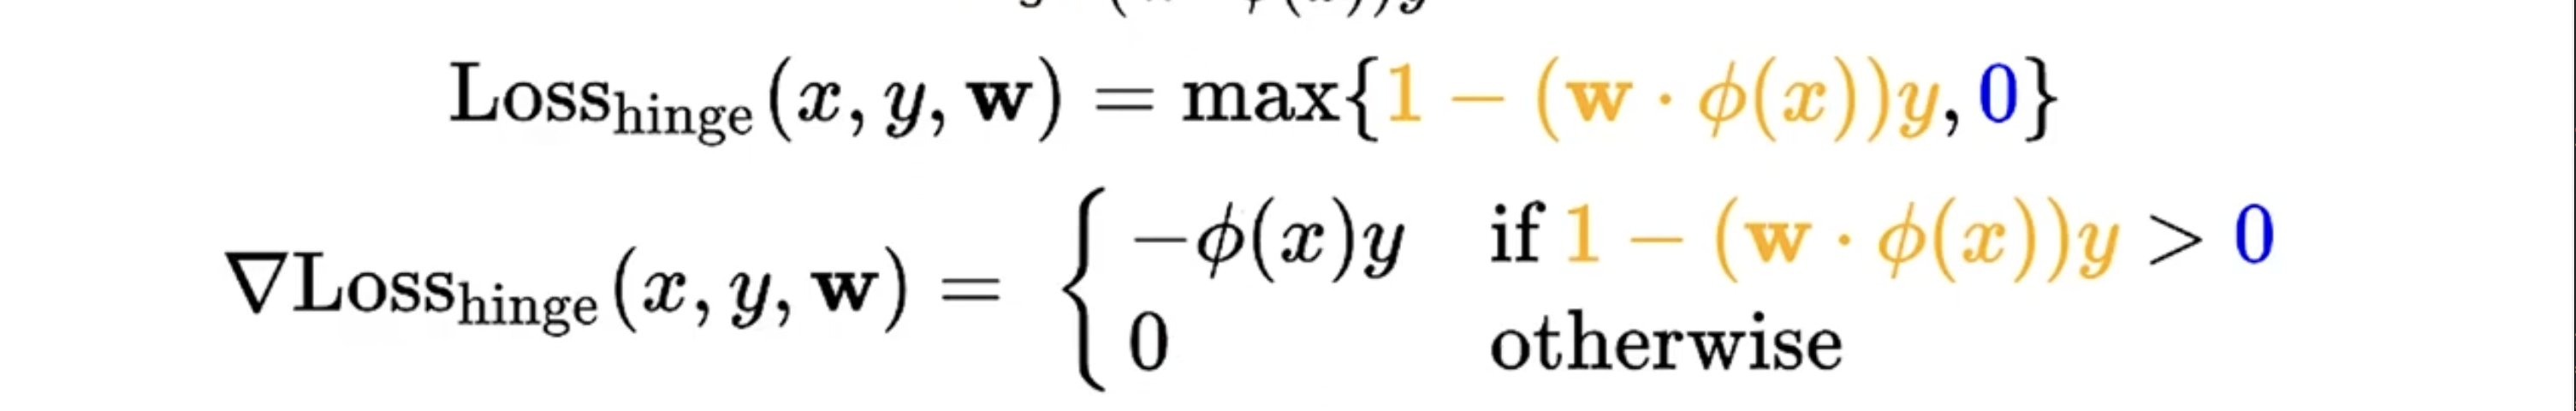

In [19]:
def gradient_loss_hinge(weights, train_data):
    gradients = []
    for x, y in train_data:
        if 1 - dot(weights, x) * y > 0:
            gradients.append([-v for v in vector_scalar_multiply(phi(x), y)])
        else:
            gradients.append([0,0])
    return vector_scalar_division(vector_summation(gradients), len(train_data))

#run gradient descent hinge variation
weights = [.5, 1]
d_train = [[[0,2], 1], [[-2,0], 1], [[1,-1], -1]]
gradient = gradient_loss_hinge(weights, d_train)

## Should be [1, -.33]
print(gradient)

        

[1.0, -0.333]


Great! Now let's sanity check with a single adjustment and make sure loss goes down ...

In [20]:
step_size = .01

print("old weights ", weights)
print("old loss ", hinge_train_loss(weights, d_train))
weights = [round(weights[i] - gradient[i] * step_size, 3) for i in range(len(gradient))]
print("new weights ", weights)
print("new loss", hinge_train_loss(weights, d_train))



old weights  [0.5, 1]
old loss  0.8333333333333334
new weights  [0.49, 1.003]
new loss 0.8223333333333334


It went down!! Wahoo... Now let's wrap this in a function and run 100 cycles

In [37]:
weights = [0,0]

def hinge_gradient_descent(weights, train_data, cycles):
    for _ in range(cycles):
        gradient = gradient_loss_hinge(weights, train_data)
        weights = [weights[i] - gradient[i] * step_size for i in range(len(gradient))]
        train_loss = hinge_train_loss(weights, d_train)
        print("w ", weights)
        print("tl ", train_loss)

hinge_gradient_descent(weights, d_train,50)

w  [-0.01, 0.01]
tl  0.98
w  [-0.02, 0.02]
tl  0.96
w  [-0.03, 0.03]
tl  0.94
w  [-0.04, 0.04]
tl  0.92
w  [-0.05, 0.05]
tl  0.9
w  [-0.060000000000000005, 0.060000000000000005]
tl  0.88
w  [-0.07, 0.07]
tl  0.86
w  [-0.08, 0.08]
tl  0.84
w  [-0.09, 0.09]
tl  0.82
w  [-0.09999999999999999, 0.09999999999999999]
tl  0.8000000000000002
w  [-0.10999999999999999, 0.10999999999999999]
tl  0.7799999999999999
w  [-0.11999999999999998, 0.11999999999999998]
tl  0.7600000000000001
w  [-0.12999999999999998, 0.12999999999999998]
tl  0.7399999999999999
w  [-0.13999999999999999, 0.13999999999999999]
tl  0.7200000000000001
w  [-0.15, 0.15]
tl  0.6999999999999998
w  [-0.16, 0.16]
tl  0.68
w  [-0.17, 0.17]
tl  0.6599999999999999
w  [-0.18000000000000002, 0.18000000000000002]
tl  0.6399999999999999
w  [-0.19000000000000003, 0.19000000000000003]
tl  0.6199999999999999
w  [-0.20000000000000004, 0.20000000000000004]
tl  0.5999999999999999
w  [-0.21000000000000005, 0.21000000000000005]
tl  0.5799999999999998

### Stochastic Gradient Descent

There is still one more optimiation we can make.

Note that we only update the weights once train_loss has been determined. 

If we have 1 million train examples, we have to go thru all of them to make them update.

STOCHASTIC GRADIENT DESCENT adjusts the weights after just one loss calculation (or every n calculation)

Let's write it below



In [41]:
weights = [0,0]

def stochastic_hinge_gradient_descent(weights, train_data, cycles):
    for _ in range(cycles):
        # for each cycle, loop through train data
        for x, y in train_data:
            gradient = [0,0]
            if 1 - dot(weights, x) * y > 0:
                gradient = ([-v for v in vector_scalar_multiply(phi(x), y)])
                
            # and calculate gradienta and update the weights for each loop
            weights = [weights[i] - gradient[i] * step_size for i in range(len(gradient))]
            train_loss = hinge_train_loss(weights, d_train)
            print("w ", weights)
            print("tl ", train_loss)

stochastic_hinge_gradient_descent(weights, d_train, 17)

w  [0.0, 0.02]
tl  0.98
w  [-0.02, 0.02]
tl  0.96
w  [-0.03, 0.03]
tl  0.94
w  [-0.03, 0.05]
tl  0.9199999999999999
w  [-0.05, 0.05]
tl  0.9
w  [-0.060000000000000005, 0.060000000000000005]
tl  0.88
w  [-0.060000000000000005, 0.08]
tl  0.86
w  [-0.08, 0.08]
tl  0.84
w  [-0.09, 0.09]
tl  0.82
w  [-0.09, 0.11]
tl  0.8000000000000002
w  [-0.11, 0.11]
tl  0.7799999999999999
w  [-0.12, 0.12]
tl  0.7600000000000001
w  [-0.12, 0.13999999999999999]
tl  0.7399999999999999
w  [-0.13999999999999999, 0.13999999999999999]
tl  0.7200000000000001
w  [-0.15, 0.15]
tl  0.6999999999999998
w  [-0.15, 0.16999999999999998]
tl  0.68
w  [-0.16999999999999998, 0.16999999999999998]
tl  0.66
w  [-0.18, 0.18]
tl  0.64
w  [-0.18, 0.19999999999999998]
tl  0.6200000000000001
w  [-0.19999999999999998, 0.19999999999999998]
tl  0.6000000000000001
w  [-0.21, 0.21]
tl  0.5800000000000001
w  [-0.21, 0.22999999999999998]
tl  0.56
w  [-0.22999999999999998, 0.22999999999999998]
tl  0.54
w  [-0.24, 0.24]
tl  0.52
w  [-0.24, 

## Conclusion

We got to 0 training loss with 17 cycles instead of 50!!

Pretty nice huh